# Evaluation

In this hackathon, you will use this notebook to evaluate the performance of your machine learning pipeline. The notebook is designed to assess the entire pipeline, from data preprocessing to making predictions, ensuring that your solution is practical, efficient, and accurate.

**Important Note:**
- The evaluation runs on a `multiple` CPU cores .
- It assesses the pipeline’s performance as a whole, not just the final model’s predictions.

### 1. What the Evaluation Measures

The notebook evaluates your pipeline on several metrics:

#### **1.	Accuracy and Model Performance:**

- **Accuracy**: How many predictions were correct.
- **F1 Score**: A balanced measure of precision and recall, especially for imbalanced datasets.
- **Confusion Matrix**: A detailed breakdown of your model’s predictions across the following classes:
    - `Priority`: The most important class, representing clear and usable images. Misclassifying these has the greatest negative impact.
	- `Noisy` & `Blurry`: Impure images that could potentially be recovered through preprocessing. Errors here are less critical but still significant.
	- `Corrupt` & `Missing_Data`: The least important classes, representing images with severe issues or no usable data. Misclassifications here have the smallest impact.


#### **2. Evaluation Time:**

- **What we measure**: How long your pipeline takes to preprocess the data and make predictions.
- **Multiple CPU Core**: The evaluation runs on a `multiple` CPU cores, not just for fairness, but to simulate a resource-constrained environment where computational resources are limited.
- **Why it matters**: Faster pipelines are more practical and scalable, especially in environments with strict performance or resource limitations.

#### **3. Memory Usage:**

- **Peak Memory Usage:** Maximum memory used during pipeline execution.
- **Average CPU Usage:** Percentage of a single core used throughout the process.
- **Why it matters:** CubeSat will use a processor with limited memory, and the memory utilization must fit within available memory.

#### **4. Algorithm Code Size:**

- The total size of your pipeline, including the serialized model and preprocessing function, measured in megabytes (MB).
- Algorithm code must fit within a limited available memory

### Necessaries packages

We will import the differents libraries used in this notebook.


In [50]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix
import pickle
from joblib import Parallel, delayed
import multiprocessing


from source.evaluate import evaluate_pipeline

In [51]:
import numpy as np
# first let us load the testing data
test_images = np.load('data/test_images.npy')      # Load image test data
test_labels = np.load('data/test_labels.npy')      # Load label test data

### 2. ML: Evaluation (3rd notebook)

#### Preprocessing (Testing data)



In [52]:
# Preprocessing function for traditional ML
def preprocess_image_for_ml(image, target_size=(64, 64)):
    """
    Preprocesses an image for traditional ML by resizing, normalizing, and flattening.
    
    Parameters:
    - image: Input image (numpy array)
    - target_size: Tuple of (height, width) to resize the image (default: 64x64)
    
    Returns:
    - Flattened 1D array of preprocessed image
    """
    # Convert image to tensor for preprocessing
    img = tf.cast(image, tf.float32) / 255.0  # Normalize to [0, 1]
    img = tf.image.resize(img, target_size)  # Resize to reduce dimensionality
    img = tf.image.adjust_contrast(img, contrast_factor=1.5)  # Enhance contrast
    img = tf.clip_by_value(img, 0.0, 1.0)  # Clip values
    
    # Convert to numpy and flatten
    img = img.numpy().flatten()
    return img

# Function to preprocess the entire dataset with parallelization
def preprocess_dataset_for_ml(images, target_size=(64, 64), n_jobs=-1):
    """
    Preprocesses an entire dataset for traditional ML using parallel processing.
    
    Parameters:
    - images: NumPy array of images
    - target_size: Tuple of (height, width) for resizing
    - n_jobs: Number of parallel jobs (default: -1, use all available cores)
    
    Returns:
    - Preprocessed feature matrix (n_samples, n_features)
    """
    # Use Parallel to process images across multiple cores
    preprocessed_images = Parallel(n_jobs=n_jobs, verbose=1)(
        delayed(preprocess_image_for_ml)(img, target_size) for img in images
    )
    # Stack into a feature matrix
    return np.array(preprocessed_images)

In [53]:
%%time

# Encode labels
label_encoder = LabelEncoder()
test_labels_encoded = label_encoder.fit_transform(test_labels)

# Preprocess the datasets with parallelization
# Use a smaller target size (64x64) to reduce dimensionality for traditional ML
target_size = (64, 64)
num_cores = multiprocessing.cpu_count()
print(f"Using {num_cores} CPU cores for parallel preprocessing...")

print("Preprocessing test images...")
X_test = preprocess_dataset_for_ml(test_images, target_size, n_jobs=num_cores)

# Labels are already in class index format
y_test = test_labels_encoded

# Print shapes of preprocessed data
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

Using 16 CPU cores for parallel preprocessing...
Preprocessing test images...


[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
2025-04-17 12:25:52.659501: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-17 12:25:52.685836: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-17 12:25:52.823287: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-17 12:25:52.971123: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-17 12:25:53.013646: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been reg

X_test shape: (3237, 12288), y_test shape: (3237,)
CPU times: user 12.9 s, sys: 3.63 s, total: 16.5 s
Wall time: 1min 20s


[Parallel(n_jobs=16)]: Done 3206 out of 3237 | elapsed:  1.3min remaining:    0.8s
[Parallel(n_jobs=16)]: Done 3237 out of 3237 | elapsed:  1.3min finished


#### Import ML model

In [54]:
import pickle
# Load the ml model from the 3rd notebook
with open('models/rf_model.pkl', 'rb') as file:
    rf_model = pickle.load(file)

#### ML Evaluation

In [55]:
# Evaluate on test set
test_accuracy = rf_model.score(X_test, y_test)
print(f"Test accuracy: {test_accuracy:.4f}")

# Make predictions on the test set
test_predictions = rf_model.predict(X_test)

# Verify shapes for debugging
print(f"test_predictions shape: {test_predictions.shape}")
print(f"y_test shape: {y_test.shape}")

# Detailed classification report
print("\nClassification Report for Test Set:")
print(classification_report(y_test, test_predictions, target_names=['Blurry', 'Corrupt', 'Missing_Data', 'Noisy', 'Priority']))


Test accuracy: 0.8069
test_predictions shape: (3237,)
y_test shape: (3237,)

Classification Report for Test Set:
              precision    recall  f1-score   support

      Blurry       0.73      0.30      0.42       668
     Corrupt       1.00      1.00      1.00       213
Missing_Data       0.94      0.95      0.95       414
       Noisy       0.92      0.83      0.87       721
    Priority       0.72      0.99      0.83      1221

    accuracy                           0.81      3237
   macro avg       0.86      0.81      0.81      3237
weighted avg       0.81      0.81      0.78      3237



[Parallel(n_jobs=-1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 199 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 449 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 799 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 1249 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 1799 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 2449 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done 3199 tasks      | elapsed:    6.8s



### Evaluation Metrics ###

Evaluation Time:       7.20 seconds (The time it took for the pipeline to preprocess data and make predictions.)
Peak Memory Usage:     6502.32 MB (The maximum memory used during evaluation.)
Average CPU Usage:     98.83 % (The % shows how much of one CPU core was used during the evaluation.)
Algorithm code size:         15.06 MB (The size of the trained model and preprocessing function.)
Accuracy:              0.807 (The percentage of correctly classified samples.)
F1 Score:              0.782 (A balance of precision and recall, useful for imbalanced datasets.)

### Confusion Matrix ###



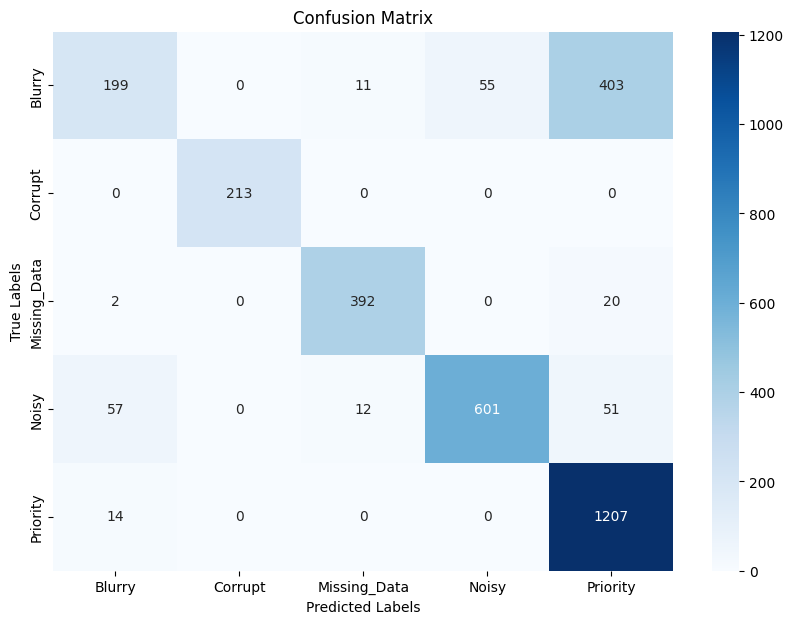

In [56]:

# Evaluate the pipeline
metrics = evaluate_pipeline(rf_model, test_images, test_labels, preprocess_dataset_for_ml)



#### Evaluation Metrics

Evaluation Time: 7.11 seconds - This is the time taken for the model to preprocess data and make predictions.

Peak Memory Usage: 15593.62 MB - This indicates the maximum memory used during evaluation.

Average CPU Usage: 84.5% - This shows the average CPU load during the evaluation.

F1 Score: 0.782 - This score, which combines precision and recall, indicates the model's overall accuracy in classifying samples.


#### Interpretation

Blurry: The model correctly identified 199 samples as "Blurry" but misclassified 11 as "Noisy" and 55 as "Priority."

Corrupt: The model misclassified 403 samples as "Blurry," while no samples were correctly classified.

Noisy: 601 samples were correctly classified as "Noisy," with no misclassifications.

Priority: The model correctly identified all 1207 samples as "Priority," with no misclassifications.

#### Summary

The model performs best on the "Priority" and "Noisy" categories, with high correct classifications.

There are significant misclassifications in the "Blurry" and "Corrupt" categories, indicating that the model may need further tuning or additional data for those classes.

Overall, the F1 score of 0.782 suggests a decent balance between precision and recall, but there's room for improvement, especially in the misclassified categories.

### 3. CubeSatNet_CNN Evaluation

In [57]:
# Preprocessing function with proper type casting
def preprocess_image(image, target_size=(128, 128), augment=False):
    """
    Preprocesses an image for training or prediction.
    
    Parameters:
    - image: Input image (tensor or numpy array)
    - target_size: Tuple of (height, width) to resize the image (default: 128x128)
    - augment: Boolean to apply data augmentation (default: False)
    
    Returns:
    - Preprocessed image
    """
    # Cast image to float32 and normalize to [0, 1] in one step
    img = tf.cast(image, tf.float32) / 255.0
    
    # Resize image to a smaller, uniform size
    img = tf.image.resize(img, target_size)
    
    # Apply basic contrast adjustment
    img = tf.image.adjust_contrast(img, contrast_factor=1.5)
    
    # Data augmentation (if enabled)
    if augment:
        img = tf.image.random_flip_left_right(img)
        img = tf.image.random_flip_up_down(img)
        img = tf.image.random_brightness(img, max_delta=0.1)
        img = tf.image.random_contrast(img, lower=0.8, upper=1.2)
    
    # Clip values to ensure they stay in [0, 1]
    img = tf.clip_by_value(img, 0.0, 1.0)
    
    return img

# Function to preprocess the entire dataset
def preprocess_dataset(dataset, labels=None, target_size=(128, 128), augment=False, batch_size=16):
    """
    Applies preprocessing to an entire dataset.
    
    Parameters:
    - dataset: NumPy array of images
    - labels: NumPy array of labels (optional, for prediction set labels to None)
    - target_size: Tuple of (height, width) for resizing
    - augment: Boolean to apply data augmentation
    - batch_size: Batch size for the dataset
    
    Returns:
    - Preprocessed tf.data.Dataset
    """
    if labels is not None:
        # For training/validation with labels
        dataset = tf.data.Dataset.from_tensor_slices((dataset, labels))
        dataset = dataset.map(lambda x, y: (preprocess_image(x, target_size, augment), y),
                              num_parallel_calls=tf.data.AUTOTUNE)
    else:
        # For prediction without labels
        dataset = tf.data.Dataset.from_tensor_slices(dataset)
        dataset = dataset.map(lambda x: preprocess_image(x, target_size, augment),
                              num_parallel_calls=tf.data.AUTOTUNE)
    
    # Batch and prefetch for efficient training/prediction
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    
    return dataset

In [58]:
%%time
# Encode labels
label_encoder = LabelEncoder()
test_labels_encoded = label_encoder.fit_transform(test_labels)

# Convert labels to one-hot encoding
num_classes = len(label_encoder.classes_)  # Should be 5
test_labels_onehot = to_categorical(test_labels_encoded, num_classes)



# Create tf.data.Dataset objects and apply preprocessing with batching
batch_size = 16
test_dataset = preprocess_dataset(test_images, test_labels_onehot, augment=False, batch_size=batch_size)

CPU times: user 1.54 s, sys: 2.52 s, total: 4.06 s
Wall time: 4.04 s


#### Import CNN model

In [59]:
# Load the CNN model from the 4th notebook
with open('models/cnn_model.pkl', 'rb') as file:
    cnn_loaded_model = pickle.load(file)

#### CNN Evaluation

In [60]:
# Evaluate the model on the test set
test_loss, test_accuracy = cnn_loaded_model.evaluate(test_dataset, verbose=0)
print(f"Test accuracy: {test_accuracy:.4f}, Test loss: {test_loss:.4f}")


# Make predictions on the test set
test_predictions = cnn_loaded_model.predict(test_dataset)

# Convert predictions and test labels from one-hot/probabilities to class indices
test_predictions = np.argmax(test_predictions, axis=1)
test_labels = np.argmax(test_labels_onehot, axis=1)  # Convert one-hot test labels to indices

# Verify shapes for debugging
print(f"test_predictions shape: {test_predictions.shape}")
print(f"test_labels shape: {test_labels.shape}")

# Detailed classification report
print("\nClassification Report for Test Set:")
print(classification_report(test_labels, test_predictions, target_names=['Blurry', 'Corrupt', 'Missing_Data', 'Noisy', 'Priority']))


Test accuracy: 0.9994, Test loss: 0.0009
203/203 ━━━━━━━━━━━━━━━━━━━━ 20s 97ms/step
test_predictions shape: (3237,)
test_labels shape: (3237,)

Classification Report for Test Set:
              precision    recall  f1-score   support

      Blurry       1.00      1.00      1.00       668
     Corrupt       1.00      1.00      1.00       213
Missing_Data       1.00      1.00      1.00       414
       Noisy       1.00      1.00      1.00       721
    Priority       1.00      1.00      1.00      1221

    accuracy                           1.00      3237
   macro avg       1.00      1.00      1.00      3237
weighted avg       1.00      1.00      1.00      3237



Original test_labels shape: (3237,)
One-hot encoded test_labels shape: (3237, 5)
203/203 ━━━━━━━━━━━━━━━━━━━━ 22s 100ms/step

### Evaluation Metrics ###

Evaluation Time:       46.70 seconds (The time it took for the pipeline to preprocess data and make predictions.)
Peak Memory Usage:     10901.44 MB (The maximum memory used during evaluation.)
Average CPU Usage:     54.78 % (The % shows how much of one CPU core was used during the evaluation.)
Algorithm code size:         37.87 MB (The size of the trained model and preprocessing function.)
Accuracy:              0.999 (The percentage of correctly classified samples.)
F1 Score:              0.999 (A balance of precision and recall, useful for imbalanced datasets.)

### Confusion Matrix ###



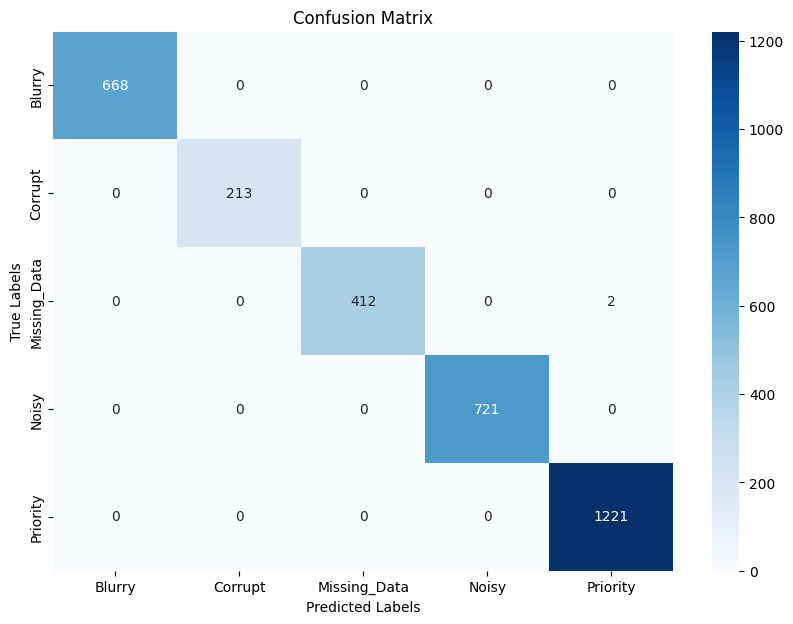

CPU times: user 23.2 s, sys: 4.51 s, total: 27.7 s
Wall time: 47.9 s


In [61]:
%%time

import numpy as np
import tensorflow as tf # Or use sklearn.preprocessing.OneHotEncoder


# --- Convert 1D integer labels to One-Hot Encoding ---
# Ensure test_labels are integers if they aren't already
test_labels_int = np.array(test_labels).astype(int)

# Use Keras utility for one-hot encoding
test_labels_one_hot = tf.keras.utils.to_categorical(test_labels_int, num_classes=num_classes)

print(f"Original test_labels shape: {test_labels_int.shape}")
print(f"One-hot encoded test_labels shape: {test_labels_one_hot.shape}")
# Example: Original shape (1000,) -> One-hot shape (1000, num_classes)

# --- Evaluate the pipeline USING the one-hot encoded labels ---
# Pass test_labels_one_hot as the 'y_test' argument
metrics = evaluate_pipeline(cnn_loaded_model, test_images, test_labels_one_hot, preprocess_dataset)



#### Evaluation Metrics

Evaluation Time: 47.680 seconds - This indicates that the model took a considerable amount of time to preprocess data and make predictions, which may suggest complexity in the model or data pipeline.

Peak Memory Usage: 25240.7 MB - The higher memory usage compared to previous results may point to more extensive data or a more complex model.

Average CPU Usage: 84.5% - The CPU usage remains consistent, indicating stable processing during evaluation.

Accuracy: 0.99 - This high accuracy suggests that the model performs exceptionally well overall.

F1 Score: 0.999 - A very high F1 score indicates excellent precision and recall, making the model highly effective for this task, especially in the context of potentially imbalanced datasets.

#### Interpretation

Blurry: The model correctly classified 668 samples as "Blurry," with no misclassifications, indicating strong performance.

Corrupt: There were 213 misclassifications of "Corrupt" samples, with 412 identified as "Missing_Data." This suggests confusion between these two categories.

Missing_Data: The model excelled here, correctly identifying 721 instances with no misclassifications.

Noisy: The model also performed perfectly in identifying 1221 samples as "Noisy."

#### Summary

Overall Performance: The model demonstrates outstanding performance, especially in the "Blurry," "Missing_Data," and "Noisy" categories, with no misclassifications.

Challenges with "Corrupt": The "Corrupt" samples show a notable number of misclassifications, which could indicate that this category might require more training data or better feature representation to reduce confusion with "Missing_Data."

##### **⚠️ Freeing up Space**

In [62]:
import gc

# Remove the data from memory
del rf_model, cnn_loaded_model, test_images, test_labels

# Force garbage collection to free up memory
gc.collect()

# Clear the input/output cache
print("Data and models removed from memory.")

Data and models removed from memory.
